<a href="https://colab.research.google.com/github/Tamar-m/RAVIR/blob/main/RAVIR_segformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 69.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.8 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW
import torch
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import os
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor, SegformerImageProcessor
import pandas as pd
import cv2
import numpy as np
import albumentations as aug
from sklearn.metrics import classification_report
from prettytable import PrettyTable
import matplotlib.pyplot as plt

In [ ]:
WIDTH = 768
HEIGHT = 768
# in training we randomly crop image to 256. In test dataset we need to employ a sliding window (9 windows per image) and reconstruct the full label predictions

# Patch size
Hp = 256
Wp = 256


In [ ]:
class ImageSegmentationDataset(Dataset):
    """Image segmentation dataset."""

    def __init__(self, root_dir, feature_extractor, transforms=None, train=True):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            feature_extractor (SegFormerFeatureExtractor): feature extractor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        self.root_dir = root_dir
        self.feature_extractor = feature_extractor
        self.train = train
        self.transforms = transforms

        sub_path = "train" if self.train else "validation"
        self.img_dir = os.path.join(self.root_dir, sub_path,"images")
        self.ann_dir = os.path.join(self.root_dir, sub_path, "mask")

        # read images
        image_file_names = []
        for root, dirs, files in os.walk(self.img_dir):
            image_file_names.extend(files)
        self.images = sorted(image_file_names)
        # read annotations
        annotation_file_names = []

        for root, dirs, files in os.walk(self.ann_dir):
            annotation_file_names.extend(files)
        self.annotations = sorted(annotation_file_names)

        assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image = cv2.imread(os.path.join(self.img_dir, self.images[idx]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        segmentation_map = cv2.imread(os.path.join(self.ann_dir, self.annotations[idx]))
        segmentation_map = cv2.cvtColor(segmentation_map, cv2.COLOR_BGR2GRAY)
        segmentation_map[segmentation_map==128]=1 # the loss in the segformer network only works of the labels are 0,1,2,3,... etc so i changed it
        segmentation_map[segmentation_map==255]=2

        if self.transforms is not None:
            augmented = self.transforms(image=image, mask=segmentation_map)
            encoded_inputs = self.feature_extractor(augmented['image'], augmented['mask'], return_tensors="pt")
        else:
            encoded_inputs = self.feature_extractor(image, segmentation_map, return_tensors="pt")


        for k,v in encoded_inputs.items():
            encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

In [ ]:
transform = aug.Compose([
    aug.Flip(p=0.5),
    aug.RandomCrop(width=256, height=256),
    aug.RandomBrightnessContrast(p=0.2),
    aug.SafeRotate(p=0.5)
])

transform_val = aug.Compose([
    aug.RandomCrop(width=256, height=256),
])


In [ ]:
root_dir = './drive/MyDrive/Deep Learning Class/RAVIR'
feature_extractor = SegformerImageProcessor(do_resize=False,align=False, reduce_zero_label=False,do_normalize = False)

train_dataset = ImageSegmentationDataset(root_dir=root_dir, feature_extractor=feature_extractor, transforms=transform)
valid_dataset = ImageSegmentationDataset(root_dir=root_dir, feature_extractor=feature_extractor, transforms=transform_val, train=False)
valid_dataset_test = ImageSegmentationDataset(root_dir=root_dir, feature_extractor=feature_extractor, transforms=None, train=False)
#when we hand in the real train set, we need to make sure the labels return to the original instead of 0 1 2!!


In [ ]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(valid_dataset))


Number of training examples: 19
Number of validation examples: 4


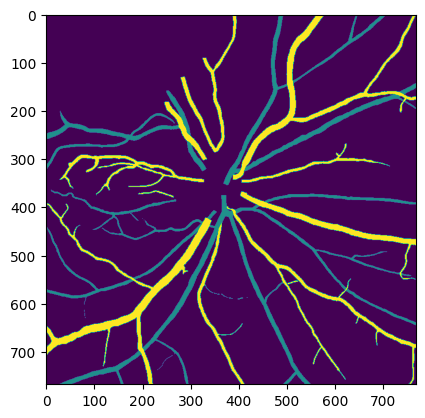

In [ ]:
encoded_inputs = valid_dataset_test[3]
import matplotlib.pyplot as plt
mask = encoded_inputs["labels"]
plt.imshow(mask.numpy())
# mask2 = mask[0:256,0:256]
# plt.imshow(mask2.numpy())

In [ ]:
encoded_inputs["pixel_values"].shape

torch.Size([3, 768, 768])

In [ ]:
encoded_inputs["labels"].shape

torch.Size([768, 768])

In [ ]:
encoded_inputs["labels"]

tensor([[0, 0, 0,  ..., 2, 2, 2],
        [0, 0, 0,  ..., 2, 2, 2],
        [0, 0, 0,  ..., 2, 2, 2],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [ ]:
encoded_inputs["labels"].squeeze().unique()

tensor([0, 1, 2])

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=4)

In [ ]:
batch = next(iter(train_dataloader))
print(type(batch))

In [ ]:
for k,v in batch.items():
    print(k, v.shape)

In [ ]:
batch["labels"].shape

In [ ]:
label2id = {"Background":0,"Artery":1,"Vein":2}
id2label = {v: k for k, v in label2id.items()}

In [ ]:
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b5", ignore_mismatched_sizes=True,
                                                         num_labels=len(id2label), id2label=id2label, label2id=label2id,
                                                         reshape_last_stage=True)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b5 and are newly initialized: ['decode_head.batch_norm.weight', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.classifier.weight', 'decode_head.batch_norm.running_var', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight', 'decode_head.batch_norm.bias', 'decode_head.linear_c.2.proj.bias', 'decode_head.classifier.bias', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.batch_norm.running_mean']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
optimizer = AdamW(model.parameters(), lr=0.0006)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Model Initialized!")

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Model Initialized!


In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
    # y_true = tf.cast(y_true, tf.float32)
    # y_pred = tf.cast(y_pred, tf.float32)
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (np.sum(y_true_f) + np.sum(y_pred_f))
def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [ ]:
NUM_EPOCHS = 300
for epoch in range(1, NUM_EPOCHS):  # loop over the dataset multiple times
    print("Epoch:", epoch)
    pbar = tqdm(train_dataloader)
    accuracies = []
    losses = []
    val_accuracies = []
    val_losses = []
    model.train()
    for idx, batch in enumerate(pbar):
        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = model(pixel_values=pixel_values, labels=labels)

        # evaluate
        upsampled_logits = nn.functional.interpolate(outputs.logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
        predicted = upsampled_logits.argmax(dim=1)

        mask = (labels != 0) # we don't include the background class in the accuracy calculation
        pred_labels = predicted[mask].detach().cpu().numpy()
        true_labels = labels[mask].detach().cpu().numpy()
        accuracy = accuracy_score(pred_labels, true_labels)
        # loss = dice_coef_loss(true_labels, pred_labels)
        loss = outputs.loss
        accuracies.append(accuracy)
        losses.append(loss.item())
        pbar.set_postfix({'Batch': idx, 'Pixel-wise accuracy': sum(accuracies)/len(accuracies), 'Loss': sum(losses)/len(losses)})

        # backward + optimize
        loss.backward()
        optimizer.step()
    else:
        model.eval()
        with torch.no_grad():
            for idx, batch in enumerate(valid_dataloader):
                pixel_values = batch["pixel_values"].to(device)
                labels = batch["labels"].to(device)

                outputs = model(pixel_values=pixel_values, labels=labels)
                upsampled_logits = nn.functional.interpolate(outputs.logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
                predicted = upsampled_logits.argmax(dim=1)

                mask = (labels != 0) # we don't include the background class in the accuracy calculation
                pred_labels = predicted[mask].detach().cpu().numpy()
                true_labels = labels[mask].detach().cpu().numpy()
                accuracy = accuracy_score(pred_labels, true_labels)
                val_loss = outputs.loss
                val_accuracies.append(accuracy)
                val_losses.append(val_loss.item())

    print(f"Train Pixel-wise accuracy: {sum(accuracies)/len(accuracies)}\
         Train Loss: {sum(losses)/len(losses)}\
         Val Pixel-wise accuracy: {sum(val_accuracies)/len(val_accuracies)}\
         Val Loss: {sum(val_losses)/len(val_losses)}")

Epoch: 1


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6154813266839619         Train Loss: 0.17837788462638854         Val Pixel-wise accuracy: 0.6230962193155348         Val Loss: 0.2126108855009079
Epoch: 2


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.5909929771457789         Train Loss: 0.19399720132350923         Val Pixel-wise accuracy: 0.6408704883227176         Val Loss: 0.14621353149414062
Epoch: 3


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.5992376943442224         Train Loss: 0.199153134226799         Val Pixel-wise accuracy: 0.6950166699785829         Val Loss: 0.2019403874874115
Epoch: 4


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6392916699908792         Train Loss: 0.18721566200256348         Val Pixel-wise accuracy: 0.6563277872396175         Val Loss: 0.18913114070892334
Epoch: 5


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6215596000422865         Train Loss: 0.19490989446640014         Val Pixel-wise accuracy: 0.6913759299546102         Val Loss: 0.1683448851108551
Epoch: 6


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6110234785700795         Train Loss: 0.17745705246925353         Val Pixel-wise accuracy: 0.7419254335860421         Val Loss: 0.14187376201152802
Epoch: 7


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6120775638920953         Train Loss: 0.19239653050899505         Val Pixel-wise accuracy: 0.6684485131717934         Val Loss: 0.14908483624458313
Epoch: 8


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6307697392973637         Train Loss: 0.18528369069099426         Val Pixel-wise accuracy: 0.7502331317871431         Val Loss: 0.12810631096363068
Epoch: 9


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6158200102373206         Train Loss: 0.18194849491119386         Val Pixel-wise accuracy: 0.6148660635089587         Val Loss: 0.1794758141040802
Epoch: 10


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.545569038647874         Train Loss: 0.19602685272693635         Val Pixel-wise accuracy: 0.6491476398547603         Val Loss: 0.1796748787164688
Epoch: 11


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6502082426175269         Train Loss: 0.1828429400920868         Val Pixel-wise accuracy: 0.726865099265465         Val Loss: 0.15345752239227295
Epoch: 12


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.630119347067318         Train Loss: 0.17556385695934296         Val Pixel-wise accuracy: 0.6911069969356486         Val Loss: 0.13113853335380554
Epoch: 13


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.5772268616708264         Train Loss: 0.1980622351169586         Val Pixel-wise accuracy: 0.6922996959380441         Val Loss: 0.17603597044944763
Epoch: 14


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.625505563908827         Train Loss: 0.18596750497817993         Val Pixel-wise accuracy: 0.7176923554617152         Val Loss: 0.15010789036750793
Epoch: 15


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6580776200465045         Train Loss: 0.18362835049629211         Val Pixel-wise accuracy: 0.6211991946217111         Val Loss: 0.16247135400772095
Epoch: 16


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6153254970352091         Train Loss: 0.19319275617599488         Val Pixel-wise accuracy: 0.7033650329188003         Val Loss: 0.16854023933410645
Epoch: 17


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6570357094279082         Train Loss: 0.16728593409061432         Val Pixel-wise accuracy: 0.7510162601626016         Val Loss: 0.12211816757917404
Epoch: 18


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6136957459366814         Train Loss: 0.18370997309684753         Val Pixel-wise accuracy: 0.7177671068427371         Val Loss: 0.15661655366420746
Epoch: 19


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6410633134000896         Train Loss: 0.18145610392093658         Val Pixel-wise accuracy: 0.5598063262510751         Val Loss: 0.21426792442798615
Epoch: 20


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.667347371900397         Train Loss: 0.1713162273168564         Val Pixel-wise accuracy: 0.6753463314520267         Val Loss: 0.16632498800754547
Epoch: 21


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.587146770103899         Train Loss: 0.18162211179733276         Val Pixel-wise accuracy: 0.6517732693201177         Val Loss: 0.1955864280462265
Epoch: 22


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6421132875949965         Train Loss: 0.1833794206380844         Val Pixel-wise accuracy: 0.7639882334726738         Val Loss: 0.17946311831474304
Epoch: 23


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6597812343466         Train Loss: 0.1794436365365982         Val Pixel-wise accuracy: 0.7184770820252298         Val Loss: 0.17852233350276947
Epoch: 24


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6422550671443984         Train Loss: 0.18209434151649476         Val Pixel-wise accuracy: 0.6945689843200931         Val Loss: 0.18755409121513367
Epoch: 25


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6327210656228509         Train Loss: 0.17919424474239348         Val Pixel-wise accuracy: 0.7108156853618803         Val Loss: 0.16813400387763977
Epoch: 26


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6541870513972861         Train Loss: 0.17471375763416291         Val Pixel-wise accuracy: 0.7348359956796089         Val Loss: 0.16127142310142517
Epoch: 27


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6287176222664229         Train Loss: 0.18107225000858307         Val Pixel-wise accuracy: 0.6936565523306948         Val Loss: 0.16701871156692505
Epoch: 28


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.5805248368993523         Train Loss: 0.18005269765853882         Val Pixel-wise accuracy: 0.7037037037037037         Val Loss: 0.17046844959259033
Epoch: 29


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6209553460788526         Train Loss: 0.17717354893684387         Val Pixel-wise accuracy: 0.8219798103084395         Val Loss: 0.1260913610458374
Epoch: 30


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6359421691138754         Train Loss: 0.17825902700424195         Val Pixel-wise accuracy: 0.696727875979635         Val Loss: 0.17798395454883575
Epoch: 31


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6033348762329032         Train Loss: 0.16449477672576904         Val Pixel-wise accuracy: 0.7039974710463546         Val Loss: 0.14503031969070435
Epoch: 32


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6085882775179765         Train Loss: 0.1780918300151825         Val Pixel-wise accuracy: 0.7090310786106033         Val Loss: 0.21097752451896667
Epoch: 33


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6788650507109706         Train Loss: 0.17615582197904586         Val Pixel-wise accuracy: 0.7301825832143662         Val Loss: 0.18051481246948242
Epoch: 34


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.650847729814162         Train Loss: 0.18041010499000548         Val Pixel-wise accuracy: 0.6738483884354682         Val Loss: 0.14763040840625763
Epoch: 35


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6195917050814839         Train Loss: 0.18390889167785646         Val Pixel-wise accuracy: 0.6622661968013012         Val Loss: 0.1719878911972046
Epoch: 36


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6131428752560979         Train Loss: 0.17865995764732362         Val Pixel-wise accuracy: 0.6829936328389001         Val Loss: 0.1268143355846405
Epoch: 37


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6082006942393292         Train Loss: 0.19450485706329346         Val Pixel-wise accuracy: 0.7384362365517714         Val Loss: 0.16609688103199005
Epoch: 38


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.611541196054073         Train Loss: 0.20046664476394654         Val Pixel-wise accuracy: 0.640045865873311         Val Loss: 0.17760777473449707
Epoch: 39


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.5696383481995033         Train Loss: 0.17700232267379762         Val Pixel-wise accuracy: 0.75991601624903         Val Loss: 0.17116035521030426
Epoch: 40


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6176648328563468         Train Loss: 0.18780288398265838         Val Pixel-wise accuracy: 0.740423851520337         Val Loss: 0.16447624564170837
Epoch: 41


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.65424384415615         Train Loss: 0.17410826086997985         Val Pixel-wise accuracy: 0.7862534552413353         Val Loss: 0.12986278533935547
Epoch: 42


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6590651526976306         Train Loss: 0.17225852906703948         Val Pixel-wise accuracy: 0.729238423268274         Val Loss: 0.16728201508522034
Epoch: 43


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6184058862290887         Train Loss: 0.20924769937992097         Val Pixel-wise accuracy: 0.7813519678900407         Val Loss: 0.12832923233509064
Epoch: 44


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.5676197966117439         Train Loss: 0.1874924272298813         Val Pixel-wise accuracy: 0.617471984576455         Val Loss: 0.22316789627075195
Epoch: 45


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.5823074829004076         Train Loss: 0.1688576340675354         Val Pixel-wise accuracy: 0.7345082433200683         Val Loss: 0.1593458652496338
Epoch: 46


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6240408473284746         Train Loss: 0.18225793540477753         Val Pixel-wise accuracy: 0.7237110550157336         Val Loss: 0.1295088529586792
Epoch: 47


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6239847229277071         Train Loss: 0.18133272230625153         Val Pixel-wise accuracy: 0.6249660048952951         Val Loss: 0.1500287652015686
Epoch: 48


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6128466291553779         Train Loss: 0.19375109076499938         Val Pixel-wise accuracy: 0.7721739130434783         Val Loss: 0.12966692447662354
Epoch: 49


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6476140773615804         Train Loss: 0.1884382039308548         Val Pixel-wise accuracy: 0.8016974626469808         Val Loss: 0.1505049467086792
Epoch: 50


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6638940071328012         Train Loss: 0.17981458604335784         Val Pixel-wise accuracy: 0.7960222932639263         Val Loss: 0.1215190589427948
Epoch: 51


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6268059753405365         Train Loss: 0.17195251286029817         Val Pixel-wise accuracy: 0.7297351169383416         Val Loss: 0.19010411202907562
Epoch: 52


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6364679486677562         Train Loss: 0.18381595313549043         Val Pixel-wise accuracy: 0.6519961881833685         Val Loss: 0.19205929338932037
Epoch: 53


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6116637661793357         Train Loss: 0.1858716517686844         Val Pixel-wise accuracy: 0.7201708659136983         Val Loss: 0.11950749158859253
Epoch: 54


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7010556671073653         Train Loss: 0.16211511939764023         Val Pixel-wise accuracy: 0.6690847140933696         Val Loss: 0.21004155278205872
Epoch: 55


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6336846622077104         Train Loss: 0.17024368345737456         Val Pixel-wise accuracy: 0.701855964467005         Val Loss: 0.12768349051475525
Epoch: 56


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6586523489816514         Train Loss: 0.15668389499187468         Val Pixel-wise accuracy: 0.7195796104647426         Val Loss: 0.15947535634040833
Epoch: 57


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6193509895485766         Train Loss: 0.17242872714996338         Val Pixel-wise accuracy: 0.7873227290149483         Val Loss: 0.16023242473602295
Epoch: 58


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6328643796606679         Train Loss: 0.18165955245494841         Val Pixel-wise accuracy: 0.6962235519798436         Val Loss: 0.15555983781814575
Epoch: 59


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6457763419498914         Train Loss: 0.1823843628168106         Val Pixel-wise accuracy: 0.6579501225313537         Val Loss: 0.1799091100692749
Epoch: 60


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6725566770364895         Train Loss: 0.17227690517902375         Val Pixel-wise accuracy: 0.6482459128065395         Val Loss: 0.1732833981513977
Epoch: 61


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.669994569271888         Train Loss: 0.16989217698574066         Val Pixel-wise accuracy: 0.713244993404485         Val Loss: 0.17113323509693146
Epoch: 62


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7070979469374139         Train Loss: 0.16168310344219208         Val Pixel-wise accuracy: 0.7332872637682901         Val Loss: 0.13936680555343628
Epoch: 63


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6772957241218689         Train Loss: 0.16919418573379516         Val Pixel-wise accuracy: 0.694234013695458         Val Loss: 0.161442831158638
Epoch: 64


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.5924907141126872         Train Loss: 0.18258741796016692         Val Pixel-wise accuracy: 0.7064628063326828         Val Loss: 0.16708552837371826
Epoch: 65


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6198303899092672         Train Loss: 0.18783502280712128         Val Pixel-wise accuracy: 0.6262208620914181         Val Loss: 0.17419716715812683
Epoch: 66


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7174132970013097         Train Loss: 0.17350422441959382         Val Pixel-wise accuracy: 0.7156973751930005         Val Loss: 0.14494763314723969
Epoch: 67


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.643230147274843         Train Loss: 0.1723628133535385         Val Pixel-wise accuracy: 0.6364035328323002         Val Loss: 0.16724704205989838
Epoch: 68


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6030480188784719         Train Loss: 0.18564458787441254         Val Pixel-wise accuracy: 0.8432416731216111         Val Loss: 0.13520073890686035
Epoch: 69


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6973254884976202         Train Loss: 0.18851015567779542         Val Pixel-wise accuracy: 0.7458196352971784         Val Loss: 0.18011394143104553
Epoch: 70


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6816597958553707         Train Loss: 0.16269638538360595         Val Pixel-wise accuracy: 0.6455160744500846         Val Loss: 0.1865767538547516
Epoch: 71


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6266396656613088         Train Loss: 0.16893636733293532         Val Pixel-wise accuracy: 0.7665880105623911         Val Loss: 0.13092760741710663
Epoch: 72


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6834556537821431         Train Loss: 0.16502087265253068         Val Pixel-wise accuracy: 0.8478415106696502         Val Loss: 0.12440143525600433
Epoch: 73


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6668948905813348         Train Loss: 0.1647657185792923         Val Pixel-wise accuracy: 0.7514775057291039         Val Loss: 0.1195598915219307
Epoch: 74


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6032820654729394         Train Loss: 0.18073625564575196         Val Pixel-wise accuracy: 0.6796358688609563         Val Loss: 0.148514062166214
Epoch: 75


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6425570069722922         Train Loss: 0.18471465408802032         Val Pixel-wise accuracy: 0.7680990814125402         Val Loss: 0.1871676743030548
Epoch: 76


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6949047247024802         Train Loss: 0.165265354514122         Val Pixel-wise accuracy: 0.6972454672245467         Val Loss: 0.14572478830814362
Epoch: 77


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6409178268924446         Train Loss: 0.17469314038753508         Val Pixel-wise accuracy: 0.7443250862781315         Val Loss: 0.15641790628433228
Epoch: 78


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6514389147551973         Train Loss: 0.17573472261428832         Val Pixel-wise accuracy: 0.7037601296596434         Val Loss: 0.1546471118927002
Epoch: 79


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6646810686220509         Train Loss: 0.18421356081962587         Val Pixel-wise accuracy: 0.795429815016322         Val Loss: 0.16070044040679932
Epoch: 80


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.5989560523626569         Train Loss: 0.19305693805217744         Val Pixel-wise accuracy: 0.6379467899010469         Val Loss: 0.18751908838748932
Epoch: 81


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6402521302668805         Train Loss: 0.16973600089550017         Val Pixel-wise accuracy: 0.7062771718404394         Val Loss: 0.11697033047676086
Epoch: 82


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6688050909964425         Train Loss: 0.1948887050151825         Val Pixel-wise accuracy: 0.6698462805380181         Val Loss: 0.15556834638118744
Epoch: 83


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6606010681938035         Train Loss: 0.1652880162000656         Val Pixel-wise accuracy: 0.6959174579234223         Val Loss: 0.12860578298568726
Epoch: 84


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6321369905895349         Train Loss: 0.1807704508304596         Val Pixel-wise accuracy: 0.7168431820917078         Val Loss: 0.14450208842754364
Epoch: 85


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6505550875110804         Train Loss: 0.19734528064727783         Val Pixel-wise accuracy: 0.8258259038806436         Val Loss: 0.14386995136737823
Epoch: 86


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6992270414847728         Train Loss: 0.16486428380012513         Val Pixel-wise accuracy: 0.714830473348255         Val Loss: 0.1664915233850479
Epoch: 87


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6717703290772545         Train Loss: 0.19341272711753846         Val Pixel-wise accuracy: 0.8106041699752705         Val Loss: 0.14127738773822784
Epoch: 88


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6735984636991252         Train Loss: 0.16747898757457733         Val Pixel-wise accuracy: 0.8061388881037845         Val Loss: 0.12271963059902191
Epoch: 89


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6314389774817906         Train Loss: 0.18456957638263702         Val Pixel-wise accuracy: 0.7052392374700164         Val Loss: 0.18814250826835632
Epoch: 90


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6706481407717778         Train Loss: 0.1624000519514084         Val Pixel-wise accuracy: 0.7310737478871987         Val Loss: 0.14473722875118256
Epoch: 91


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6569132142913494         Train Loss: 0.16720865070819854         Val Pixel-wise accuracy: 0.8193932860180277         Val Loss: 0.1097375825047493
Epoch: 92


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6721734791515546         Train Loss: 0.161396324634552         Val Pixel-wise accuracy: 0.6848390756553413         Val Loss: 0.14931994676589966
Epoch: 93


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6519908592187125         Train Loss: 0.18737658858299255         Val Pixel-wise accuracy: 0.7042610754142712         Val Loss: 0.19511519372463226
Epoch: 94


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6814093544946864         Train Loss: 0.16915152668952943         Val Pixel-wise accuracy: 0.7574447899646867         Val Loss: 0.15742352604866028
Epoch: 95


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.663011780468527         Train Loss: 0.1816159188747406         Val Pixel-wise accuracy: 0.6909577464788732         Val Loss: 0.17368723452091217
Epoch: 96


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.740235905728869         Train Loss: 0.15958565324544907         Val Pixel-wise accuracy: 0.847984077681614         Val Loss: 0.11716064810752869
Epoch: 97


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7196532164748086         Train Loss: 0.17221699655056         Val Pixel-wise accuracy: 0.7237486560745431         Val Loss: 0.16652871668338776
Epoch: 98


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6873267955001435         Train Loss: 0.15413882732391357         Val Pixel-wise accuracy: 0.6053593179049939         Val Loss: 0.1846863329410553
Epoch: 99


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6846579320281198         Train Loss: 0.16295416951179503         Val Pixel-wise accuracy: 0.8120069104520587         Val Loss: 0.12078873068094254
Epoch: 100


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6768147184025534         Train Loss: 0.17900742292404176         Val Pixel-wise accuracy: 0.6956937537570359         Val Loss: 0.16035917401313782
Epoch: 101


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6589415816257158         Train Loss: 0.1706112802028656         Val Pixel-wise accuracy: 0.6418075064067214         Val Loss: 0.16006705164909363
Epoch: 102


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.697498608172763         Train Loss: 0.15638116449117662         Val Pixel-wise accuracy: 0.7205475663716814         Val Loss: 0.16815119981765747
Epoch: 103


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6546414684693816         Train Loss: 0.16946392357349396         Val Pixel-wise accuracy: 0.7649783208513993         Val Loss: 0.16973604261875153
Epoch: 104


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.639010654622426         Train Loss: 0.18506321012973787         Val Pixel-wise accuracy: 0.7087735299333688         Val Loss: 0.19428949058055878
Epoch: 105


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6814474070869573         Train Loss: 0.18138185739517212         Val Pixel-wise accuracy: 0.7010775328214021         Val Loss: 0.17258965969085693
Epoch: 106


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6810575748541348         Train Loss: 0.1758441925048828         Val Pixel-wise accuracy: 0.6626348764357815         Val Loss: 0.1770554929971695
Epoch: 107


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.5510673356924928         Train Loss: 0.17555509507656097         Val Pixel-wise accuracy: 0.6690527614933662         Val Loss: 0.2166886329650879
Epoch: 108


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6819616589472544         Train Loss: 0.1579250141978264         Val Pixel-wise accuracy: 0.735148264345714         Val Loss: 0.13793575763702393
Epoch: 109


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7240107027177749         Train Loss: 0.17598673403263093         Val Pixel-wise accuracy: 0.7491318439634217         Val Loss: 0.15086831152439117
Epoch: 110


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6300278776118601         Train Loss: 0.18636896312236786         Val Pixel-wise accuracy: 0.8425876273582606         Val Loss: 0.12522836029529572
Epoch: 111


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6697983114435122         Train Loss: 0.17599565386772156         Val Pixel-wise accuracy: 0.8445619039628605         Val Loss: 0.1248006597161293
Epoch: 112


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7246635105019238         Train Loss: 0.17427159249782562         Val Pixel-wise accuracy: 0.7774736842105263         Val Loss: 0.13446937501430511
Epoch: 113


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6809260721848777         Train Loss: 0.1640225738286972         Val Pixel-wise accuracy: 0.7898183293251818         Val Loss: 0.13775047659873962
Epoch: 114


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6536978739861901         Train Loss: 0.1679745852947235         Val Pixel-wise accuracy: 0.5859135870090537         Val Loss: 0.20415516197681427
Epoch: 115


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6506105125457704         Train Loss: 0.177652770280838         Val Pixel-wise accuracy: 0.7221504957248301         Val Loss: 0.21220161020755768
Epoch: 116


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6750840702669183         Train Loss: 0.15431099534034728         Val Pixel-wise accuracy: 0.6219752263848087         Val Loss: 0.18407507240772247
Epoch: 117


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6238506174316614         Train Loss: 0.1651453733444214         Val Pixel-wise accuracy: 0.8173021408281564         Val Loss: 0.15108124911785126
Epoch: 118


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6877997450684497         Train Loss: 0.1597524344921112         Val Pixel-wise accuracy: 0.7472681650163235         Val Loss: 0.15684151649475098
Epoch: 119


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6741306032286323         Train Loss: 0.18287559747695922         Val Pixel-wise accuracy: 0.772105046707009         Val Loss: 0.12548185884952545
Epoch: 120


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6928662500558257         Train Loss: 0.15969239473342894         Val Pixel-wise accuracy: 0.697357768455141         Val Loss: 0.12313583493232727
Epoch: 121


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6314615171683065         Train Loss: 0.16306846737861633         Val Pixel-wise accuracy: 0.7872820403938533         Val Loss: 0.11997272074222565
Epoch: 122


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6868575818951732         Train Loss: 0.17653163373470307         Val Pixel-wise accuracy: 0.7416976760513937         Val Loss: 0.135013148188591
Epoch: 123


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.651179673993049         Train Loss: 0.165894016623497         Val Pixel-wise accuracy: 0.8064725241847013         Val Loss: 0.12398755550384521
Epoch: 124


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6650226105455818         Train Loss: 0.16595951318740845         Val Pixel-wise accuracy: 0.8003937976864386         Val Loss: 0.12458948791027069
Epoch: 125


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7597685604822069         Train Loss: 0.1486818313598633         Val Pixel-wise accuracy: 0.8191651674902648         Val Loss: 0.16472353041172028
Epoch: 126


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6393674127171145         Train Loss: 0.184209144115448         Val Pixel-wise accuracy: 0.812221396731055         Val Loss: 0.11756935715675354
Epoch: 127


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.645133480521306         Train Loss: 0.1784975200891495         Val Pixel-wise accuracy: 0.775621607030383         Val Loss: 0.11609756946563721
Epoch: 128


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6867724930513674         Train Loss: 0.177946075797081         Val Pixel-wise accuracy: 0.7876909387512976         Val Loss: 0.14175252616405487
Epoch: 129


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6443569830592847         Train Loss: 0.17630467116832732         Val Pixel-wise accuracy: 0.6746118294646103         Val Loss: 0.17385920882225037
Epoch: 130


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6647620871342947         Train Loss: 0.16215503066778184         Val Pixel-wise accuracy: 0.7751902537805794         Val Loss: 0.11923101544380188
Epoch: 131


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6149920554028394         Train Loss: 0.16645659506320953         Val Pixel-wise accuracy: 0.6830304005147178         Val Loss: 0.1921704262495041
Epoch: 132


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7065874423801987         Train Loss: 0.16455332040786744         Val Pixel-wise accuracy: 0.7769342244716977         Val Loss: 0.1714678406715393
Epoch: 133


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6589681789690807         Train Loss: 0.16616401076316833         Val Pixel-wise accuracy: 0.6200404415783146         Val Loss: 0.1806229054927826
Epoch: 134


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7301577668568235         Train Loss: 0.1657915949821472         Val Pixel-wise accuracy: 0.7953225754707901         Val Loss: 0.1147051602602005
Epoch: 135


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7085860492800973         Train Loss: 0.16334127485752106         Val Pixel-wise accuracy: 0.7700202852039117         Val Loss: 0.12577345967292786
Epoch: 136


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6573792991749292         Train Loss: 0.16943512260913848         Val Pixel-wise accuracy: 0.5925471249801996         Val Loss: 0.14369457960128784
Epoch: 137


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6504137781580033         Train Loss: 0.165938201546669         Val Pixel-wise accuracy: 0.8067420160336444         Val Loss: 0.11474762856960297
Epoch: 138


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7020358379852871         Train Loss: 0.147994664311409         Val Pixel-wise accuracy: 0.8479676953458897         Val Loss: 0.09918229281902313
Epoch: 139


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6953605962223371         Train Loss: 0.1509208157658577         Val Pixel-wise accuracy: 0.7641399665124727         Val Loss: 0.1312224566936493
Epoch: 140


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6679489776893298         Train Loss: 0.16807530522346498         Val Pixel-wise accuracy: 0.7432342708416328         Val Loss: 0.1653594672679901
Epoch: 141


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6748037228089896         Train Loss: 0.15709531903266907         Val Pixel-wise accuracy: 0.7770934015603778         Val Loss: 0.11979027837514877
Epoch: 142


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6436321325729049         Train Loss: 0.1748545929789543         Val Pixel-wise accuracy: 0.8029066363605055         Val Loss: 0.09545303881168365
Epoch: 143


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6748916839031772         Train Loss: 0.16520994901657104         Val Pixel-wise accuracy: 0.7813190108781591         Val Loss: 0.1689080148935318
Epoch: 144


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6969567755514289         Train Loss: 0.17534757852554322         Val Pixel-wise accuracy: 0.7518713524486171         Val Loss: 0.1467672437429428
Epoch: 145


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6576405428298382         Train Loss: 0.17732188999652862         Val Pixel-wise accuracy: 0.7587665854318982         Val Loss: 0.12987558543682098
Epoch: 146


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7072786477657128         Train Loss: 0.1554082840681076         Val Pixel-wise accuracy: 0.7994507570985866         Val Loss: 0.15750418603420258
Epoch: 147


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6816448747510562         Train Loss: 0.17461259067058563         Val Pixel-wise accuracy: 0.6065127140633109         Val Loss: 0.15515972673892975
Epoch: 148


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6770442614065274         Train Loss: 0.1785765379667282         Val Pixel-wise accuracy: 0.7476969308832947         Val Loss: 0.17712250351905823
Epoch: 149


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.686252238476041         Train Loss: 0.14673972427845         Val Pixel-wise accuracy: 0.7360407927093882         Val Loss: 0.13314732909202576
Epoch: 150


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6498072873641145         Train Loss: 0.17888120710849761         Val Pixel-wise accuracy: 0.665625         Val Loss: 0.2146192193031311
Epoch: 151


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.723862858110957         Train Loss: 0.15117379575967788         Val Pixel-wise accuracy: 0.6104455744204085         Val Loss: 0.1428685039281845
Epoch: 152


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6698337530204983         Train Loss: 0.1627260833978653         Val Pixel-wise accuracy: 0.6972846037572878         Val Loss: 0.14938250184059143
Epoch: 153


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6411911393723745         Train Loss: 0.16852901726961136         Val Pixel-wise accuracy: 0.6844398578144708         Val Loss: 0.16094806790351868
Epoch: 154


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6802999308451725         Train Loss: 0.17516303062438965         Val Pixel-wise accuracy: 0.7837777636352066         Val Loss: 0.1323128044605255
Epoch: 155


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6891773405666173         Train Loss: 0.1820801317691803         Val Pixel-wise accuracy: 0.6449462618194632         Val Loss: 0.20541322231292725
Epoch: 156


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6673977393175493         Train Loss: 0.16112964749336242         Val Pixel-wise accuracy: 0.7473563547786216         Val Loss: 0.14989304542541504
Epoch: 157


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7201094605250484         Train Loss: 0.15951946526765823         Val Pixel-wise accuracy: 0.8302115915363385         Val Loss: 0.11400789022445679
Epoch: 158


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6643325054333411         Train Loss: 0.16419233977794648         Val Pixel-wise accuracy: 0.7262603246938194         Val Loss: 0.17140913009643555
Epoch: 159


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6367683266402838         Train Loss: 0.16332781910896302         Val Pixel-wise accuracy: 0.730130839100346         Val Loss: 0.15984205901622772
Epoch: 160


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6466016817170944         Train Loss: 0.18098334074020386         Val Pixel-wise accuracy: 0.7544762404830664         Val Loss: 0.16639870405197144
Epoch: 161


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6663039093394892         Train Loss: 0.15563375055789946         Val Pixel-wise accuracy: 0.7496489288595417         Val Loss: 0.15407142043113708
Epoch: 162


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6742592062757368         Train Loss: 0.15929097533226014         Val Pixel-wise accuracy: 0.8190061552319472         Val Loss: 0.12637561559677124
Epoch: 163


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6627198319628116         Train Loss: 0.16597555875778197         Val Pixel-wise accuracy: 0.7486215997282396         Val Loss: 0.16078874468803406
Epoch: 164


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6534460695262723         Train Loss: 0.18430401384830475         Val Pixel-wise accuracy: 0.7154009758538722         Val Loss: 0.19493889808654785
Epoch: 165


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7111768376679208         Train Loss: 0.18011593520641328         Val Pixel-wise accuracy: 0.7494285714285714         Val Loss: 0.1599155068397522
Epoch: 166


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7127140570043998         Train Loss: 0.1547701984643936         Val Pixel-wise accuracy: 0.7533881982139731         Val Loss: 0.10571888089179993
Epoch: 167


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6083020594984812         Train Loss: 0.16424015462398528         Val Pixel-wise accuracy: 0.7161941265994025         Val Loss: 0.16513691842556
Epoch: 168


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7465848149370373         Train Loss: 0.14810207933187486         Val Pixel-wise accuracy: 0.713433027405173         Val Loss: 0.17939752340316772
Epoch: 169


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7211359559861167         Train Loss: 0.16539062857627868         Val Pixel-wise accuracy: 0.7923617308528409         Val Loss: 0.1462351679801941
Epoch: 170


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.704940219100858         Train Loss: 0.15909541845321656         Val Pixel-wise accuracy: 0.7002809865750859         Val Loss: 0.15762366354465485
Epoch: 171


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6638062389700259         Train Loss: 0.17044482827186586         Val Pixel-wise accuracy: 0.6370832203849282         Val Loss: 0.18173569440841675
Epoch: 172


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.680197300798712         Train Loss: 0.1665757566690445         Val Pixel-wise accuracy: 0.7859588548410301         Val Loss: 0.1265316605567932
Epoch: 173


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6871013837245115         Train Loss: 0.14959022253751755         Val Pixel-wise accuracy: 0.7765329908187051         Val Loss: 0.1499113142490387
Epoch: 174


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6740104554601027         Train Loss: 0.16298241466283797         Val Pixel-wise accuracy: 0.7017826336975274         Val Loss: 0.1653228998184204
Epoch: 175


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6952751806527143         Train Loss: 0.16596563756465912         Val Pixel-wise accuracy: 0.7524721718871343         Val Loss: 0.1747536063194275
Epoch: 176


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6980313800202366         Train Loss: 0.1635896921157837         Val Pixel-wise accuracy: 0.7809878293749262         Val Loss: 0.14954708516597748
Epoch: 177


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7141147998790129         Train Loss: 0.14419628381729127         Val Pixel-wise accuracy: 0.8486182812025509         Val Loss: 0.10968057811260223
Epoch: 178


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.700507050531386         Train Loss: 0.14775680005550385         Val Pixel-wise accuracy: 0.6690536917140801         Val Loss: 0.20725055038928986
Epoch: 179


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6801083450968123         Train Loss: 0.16070255488157273         Val Pixel-wise accuracy: 0.702223766504517         Val Loss: 0.13071313500404358
Epoch: 180


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7086824129832807         Train Loss: 0.13942223489284516         Val Pixel-wise accuracy: 0.681924882629108         Val Loss: 0.14068572223186493
Epoch: 181


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6998375034591031         Train Loss: 0.1422365665435791         Val Pixel-wise accuracy: 0.7731956003960714         Val Loss: 0.13855881989002228
Epoch: 182


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.676078675848268         Train Loss: 0.1614276111125946         Val Pixel-wise accuracy: 0.7249915329905477         Val Loss: 0.15542447566986084
Epoch: 183


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7218220179183152         Train Loss: 0.15755109786987304         Val Pixel-wise accuracy: 0.8007865774366456         Val Loss: 0.1260538548231125
Epoch: 184


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7006059938607305         Train Loss: 0.1567399188876152         Val Pixel-wise accuracy: 0.6981483744805671         Val Loss: 0.16616694629192352
Epoch: 185


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6983780085510679         Train Loss: 0.16152540147304534         Val Pixel-wise accuracy: 0.8241068601203327         Val Loss: 0.11381684243679047
Epoch: 186


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6528227449376599         Train Loss: 0.1771411716938019         Val Pixel-wise accuracy: 0.8477628371471259         Val Loss: 0.11762939393520355
Epoch: 187


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6987795296995303         Train Loss: 0.16930246651172637         Val Pixel-wise accuracy: 0.7279465406052117         Val Loss: 0.18277467787265778
Epoch: 188


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7079489821055878         Train Loss: 0.16323073208332062         Val Pixel-wise accuracy: 0.6760813746790441         Val Loss: 0.1692797690629959
Epoch: 189


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6445988152664097         Train Loss: 0.16175082623958587         Val Pixel-wise accuracy: 0.7788338408127259         Val Loss: 0.11105753481388092
Epoch: 190


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6693974826828073         Train Loss: 0.15463417768478394         Val Pixel-wise accuracy: 0.7377077314722119         Val Loss: 0.16456641256809235
Epoch: 191


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6699960202103952         Train Loss: 0.16671222895383836         Val Pixel-wise accuracy: 0.7525812224669604         Val Loss: 0.1274048537015915
Epoch: 192


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7098156368545299         Train Loss: 0.15273803174495698         Val Pixel-wise accuracy: 0.7787320030310685         Val Loss: 0.13233114778995514
Epoch: 193


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7395632444137484         Train Loss: 0.15663365572690963         Val Pixel-wise accuracy: 0.7662915390054207         Val Loss: 0.1507508009672165
Epoch: 194


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7107843897522701         Train Loss: 0.16353890001773835         Val Pixel-wise accuracy: 0.7081437731130444         Val Loss: 0.1995670348405838
Epoch: 195


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6484479249039128         Train Loss: 0.1686940848827362         Val Pixel-wise accuracy: 0.6715382806990048         Val Loss: 0.15293557941913605
Epoch: 196


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6549254373357366         Train Loss: 0.15976327061653137         Val Pixel-wise accuracy: 0.7018665240849657         Val Loss: 0.16592735052108765
Epoch: 197


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6548559877149958         Train Loss: 0.18304064869880676         Val Pixel-wise accuracy: 0.8385187480632166         Val Loss: 0.11768624186515808
Epoch: 198


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7051874430173043         Train Loss: 0.17105901539325713         Val Pixel-wise accuracy: 0.7544568143782289         Val Loss: 0.12771134078502655
Epoch: 199


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6814812791952001         Train Loss: 0.15204064249992372         Val Pixel-wise accuracy: 0.7805061509717808         Val Loss: 0.14679837226867676
Epoch: 200


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.645113279205343         Train Loss: 0.16485069692134857         Val Pixel-wise accuracy: 0.7738589211618258         Val Loss: 0.14922995865345
Epoch: 201


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7356799198566579         Train Loss: 0.1397315666079521         Val Pixel-wise accuracy: 0.7551324553666474         Val Loss: 0.16363540291786194
Epoch: 202


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7481691131717266         Train Loss: 0.1447589486837387         Val Pixel-wise accuracy: 0.7414774296922482         Val Loss: 0.152602881193161
Epoch: 203


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6598979789101397         Train Loss: 0.1659582167863846         Val Pixel-wise accuracy: 0.8213815428508724         Val Loss: 0.12318757176399231
Epoch: 204


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6930833568984182         Train Loss: 0.16268536746501921         Val Pixel-wise accuracy: 0.7178656721300749         Val Loss: 0.15724560618400574
Epoch: 205


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7013236827791076         Train Loss: 0.1505906581878662         Val Pixel-wise accuracy: 0.6856373965912489         Val Loss: 0.13521046936511993
Epoch: 206


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6617619304015218         Train Loss: 0.15505879521369934         Val Pixel-wise accuracy: 0.7641588773818392         Val Loss: 0.17116419970989227
Epoch: 207


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7000039347710036         Train Loss: 0.14754837155342101         Val Pixel-wise accuracy: 0.5106651421361826         Val Loss: 0.1824878305196762
Epoch: 208


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6859831161560657         Train Loss: 0.15355404913425447         Val Pixel-wise accuracy: 0.8172508861756597         Val Loss: 0.1326969861984253
Epoch: 209


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6781509319207084         Train Loss: 0.186026668548584         Val Pixel-wise accuracy: 0.8331302202538418         Val Loss: 0.11801311373710632
Epoch: 210


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6694370410083852         Train Loss: 0.16594834625720978         Val Pixel-wise accuracy: 0.6665004253821105         Val Loss: 0.1591649055480957
Epoch: 211


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6751543721054443         Train Loss: 0.16440564692020415         Val Pixel-wise accuracy: 0.7979100145137881         Val Loss: 0.12889546155929565
Epoch: 212


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7228879608533633         Train Loss: 0.15543067455291748         Val Pixel-wise accuracy: 0.6848022024843499         Val Loss: 0.14251677691936493
Epoch: 213


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7142261969203983         Train Loss: 0.1410110667347908         Val Pixel-wise accuracy: 0.7444160074453234         Val Loss: 0.1496414989233017
Epoch: 214


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.720316342730087         Train Loss: 0.15363301038742067         Val Pixel-wise accuracy: 0.7082585278276481         Val Loss: 0.17560064792633057
Epoch: 215


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7072248719579515         Train Loss: 0.16010513305664062         Val Pixel-wise accuracy: 0.7782855005077227         Val Loss: 0.12259188294410706
Epoch: 216


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7067821040303055         Train Loss: 0.15257540345191956         Val Pixel-wise accuracy: 0.7671794182844092         Val Loss: 0.12066115438938141
Epoch: 217


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6373171555925483         Train Loss: 0.1580359309911728         Val Pixel-wise accuracy: 0.5990183436629092         Val Loss: 0.14375516772270203
Epoch: 218


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6371829992844871         Train Loss: 0.1597363084554672         Val Pixel-wise accuracy: 0.5934287521746007         Val Loss: 0.14775040745735168
Epoch: 219


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6749590786929562         Train Loss: 0.16092100441455842         Val Pixel-wise accuracy: 0.8351679608612794         Val Loss: 0.12886980175971985
Epoch: 220


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6784041767705504         Train Loss: 0.16384045779705048         Val Pixel-wise accuracy: 0.7607413870600989         Val Loss: 0.16798430681228638
Epoch: 221


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.670551235048187         Train Loss: 0.15677602589130402         Val Pixel-wise accuracy: 0.7966446365022878         Val Loss: 0.10612772405147552
Epoch: 222


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7476397322804834         Train Loss: 0.14266020208597183         Val Pixel-wise accuracy: 0.7799942457082574         Val Loss: 0.11455261707305908
Epoch: 223


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.753200147751816         Train Loss: 0.14424312263727188         Val Pixel-wise accuracy: 0.762056190182155         Val Loss: 0.16367042064666748
Epoch: 224


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7181622441933972         Train Loss: 0.14902492016553878         Val Pixel-wise accuracy: 0.6955172333325554         Val Loss: 0.17549598217010498
Epoch: 225


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6593210942797489         Train Loss: 0.1689255177974701         Val Pixel-wise accuracy: 0.7206991917944312         Val Loss: 0.17878714203834534
Epoch: 226


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6802114839847985         Train Loss: 0.17496964186429978         Val Pixel-wise accuracy: 0.7910921197504326         Val Loss: 0.1884489208459854
Epoch: 227


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.727160800868285         Train Loss: 0.17199326008558274         Val Pixel-wise accuracy: 0.7282192565029161         Val Loss: 0.12755803763866425
Epoch: 228


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6698165197114637         Train Loss: 0.15512021631002426         Val Pixel-wise accuracy: 0.775455537550845         Val Loss: 0.12171158194541931
Epoch: 229


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6497805481513433         Train Loss: 0.1601916015148163         Val Pixel-wise accuracy: 0.8065558378438087         Val Loss: 0.13610625267028809
Epoch: 230


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7314167892744777         Train Loss: 0.16149251461029052         Val Pixel-wise accuracy: 0.705113349377544         Val Loss: 0.1740589588880539
Epoch: 231


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7273085747736102         Train Loss: 0.1528436630964279         Val Pixel-wise accuracy: 0.7133422634808885         Val Loss: 0.1609143167734146
Epoch: 232


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6984560588716839         Train Loss: 0.16309615820646287         Val Pixel-wise accuracy: 0.7818936877076412         Val Loss: 0.12943187355995178
Epoch: 233


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6853223315290352         Train Loss: 0.16970690786838533         Val Pixel-wise accuracy: 0.8329861111111111         Val Loss: 0.1216849833726883
Epoch: 234


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6777571978344203         Train Loss: 0.16373886168003082         Val Pixel-wise accuracy: 0.7883772570560392         Val Loss: 0.1283772736787796
Epoch: 235


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6641020464918401         Train Loss: 0.16744484603405         Val Pixel-wise accuracy: 0.7476963923161019         Val Loss: 0.1800205111503601
Epoch: 236


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7021499951641885         Train Loss: 0.156125071644783         Val Pixel-wise accuracy: 0.7239985736360395         Val Loss: 0.1289181113243103
Epoch: 237


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.722091410083896         Train Loss: 0.1575015068054199         Val Pixel-wise accuracy: 0.8118181818181818         Val Loss: 0.10914577543735504
Epoch: 238


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.751480506119921         Train Loss: 0.138980895280838         Val Pixel-wise accuracy: 0.7438127298796833         Val Loss: 0.1429939866065979
Epoch: 239


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6556161714885989         Train Loss: 0.18162390738725662         Val Pixel-wise accuracy: 0.8095313741064337         Val Loss: 0.15482845902442932
Epoch: 240


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6533418820324788         Train Loss: 0.15462972223758698         Val Pixel-wise accuracy: 0.7228050968585591         Val Loss: 0.15070731937885284
Epoch: 241


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6014693544234007         Train Loss: 0.16587979793548585         Val Pixel-wise accuracy: 0.7471439655403055         Val Loss: 0.16263984143733978
Epoch: 242


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6950583956001997         Train Loss: 0.15538738667964935         Val Pixel-wise accuracy: 0.7565004147282628         Val Loss: 0.11821287870407104
Epoch: 243


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7477727329321315         Train Loss: 0.15078039169311525         Val Pixel-wise accuracy: 0.7598021117920697         Val Loss: 0.10841161757707596
Epoch: 244


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6880974763555665         Train Loss: 0.183358633518219         Val Pixel-wise accuracy: 0.8492999351569442         Val Loss: 0.10901325941085815
Epoch: 245


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6867561055786362         Train Loss: 0.1648312360048294         Val Pixel-wise accuracy: 0.7048456750920868         Val Loss: 0.14643163979053497
Epoch: 246


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6501584615537429         Train Loss: 0.1604663163423538         Val Pixel-wise accuracy: 0.7213612959939721         Val Loss: 0.1700158715248108
Epoch: 247


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6706606887263031         Train Loss: 0.1586676999926567         Val Pixel-wise accuracy: 0.7405145110206193         Val Loss: 0.13037706911563873
Epoch: 248


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6432251431677619         Train Loss: 0.16833255290985108         Val Pixel-wise accuracy: 0.8191128105029546         Val Loss: 0.15489283204078674
Epoch: 249


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7003838861547926         Train Loss: 0.1623925656080246         Val Pixel-wise accuracy: 0.8434354986276303         Val Loss: 0.11615599691867828
Epoch: 250


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7411303336225946         Train Loss: 0.13866856843233108         Val Pixel-wise accuracy: 0.7783056566912352         Val Loss: 0.18499405682086945
Epoch: 251


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7461294978034222         Train Loss: 0.14777659773826599         Val Pixel-wise accuracy: 0.8154215358931552         Val Loss: 0.12086625397205353
Epoch: 252


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6859872979927252         Train Loss: 0.16909498274326323         Val Pixel-wise accuracy: 0.6745147582404961         Val Loss: 0.1356188803911209
Epoch: 253


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.721633177946598         Train Loss: 0.15289391875267028         Val Pixel-wise accuracy: 0.6404602397332292         Val Loss: 0.19838213920593262
Epoch: 254


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6775190899953525         Train Loss: 0.16709616184234619         Val Pixel-wise accuracy: 0.7790115392989332         Val Loss: 0.12497061491012573
Epoch: 255


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6971212767131547         Train Loss: 0.141040375828743         Val Pixel-wise accuracy: 0.8148325869055235         Val Loss: 0.1506785899400711
Epoch: 256


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7709309548449812         Train Loss: 0.13672589659690856         Val Pixel-wise accuracy: 0.7774044955494753         Val Loss: 0.11168013513088226
Epoch: 257


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7120359245594331         Train Loss: 0.16671309769153594         Val Pixel-wise accuracy: 0.8492770679219905         Val Loss: 0.11542937159538269
Epoch: 258


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6901028982430882         Train Loss: 0.1699237644672394         Val Pixel-wise accuracy: 0.765247993518495         Val Loss: 0.14750704169273376
Epoch: 259


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6966161767095926         Train Loss: 0.15665914714336396         Val Pixel-wise accuracy: 0.7708958593397254         Val Loss: 0.1473637819290161
Epoch: 260


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7085373261020929         Train Loss: 0.1526125580072403         Val Pixel-wise accuracy: 0.7833679833679834         Val Loss: 0.12268368154764175
Epoch: 261


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7249798549953285         Train Loss: 0.15167421102523804         Val Pixel-wise accuracy: 0.7876053691938794         Val Loss: 0.15225458145141602
Epoch: 262


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7422506685581653         Train Loss: 0.15543872714042664         Val Pixel-wise accuracy: 0.8077771032367319         Val Loss: 0.11347373574972153
Epoch: 263


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7192058408286341         Train Loss: 0.1563698410987854         Val Pixel-wise accuracy: 0.7297035071198242         Val Loss: 0.17762316763401031
Epoch: 264


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7127131455273031         Train Loss: 0.1379830628633499         Val Pixel-wise accuracy: 0.6254597545394711         Val Loss: 0.15627120435237885
Epoch: 265


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6845772125669439         Train Loss: 0.16016025394201278         Val Pixel-wise accuracy: 0.704793944491169         Val Loss: 0.14512665569782257
Epoch: 266


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7092124265119072         Train Loss: 0.14919244796037673         Val Pixel-wise accuracy: 0.792948275421237         Val Loss: 0.15267956256866455
Epoch: 267


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7038628872279722         Train Loss: 0.16053037941455842         Val Pixel-wise accuracy: 0.7124089783049321         Val Loss: 0.09887483716011047
Epoch: 268


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6574089396329308         Train Loss: 0.14522727876901625         Val Pixel-wise accuracy: 0.8360330480618319         Val Loss: 0.11513343453407288
Epoch: 269


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.709510253948186         Train Loss: 0.16344157755374908         Val Pixel-wise accuracy: 0.8130412488605288         Val Loss: 0.14141906797885895
Epoch: 270


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7320463953671854         Train Loss: 0.16146092414855956         Val Pixel-wise accuracy: 0.8626511046269278         Val Loss: 0.11420978605747223
Epoch: 271


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7273813448425651         Train Loss: 0.1499056488275528         Val Pixel-wise accuracy: 0.8587050644498875         Val Loss: 0.12224225699901581
Epoch: 272


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7075743235538104         Train Loss: 0.16177797615528106         Val Pixel-wise accuracy: 0.7273458100199369         Val Loss: 0.15134502947330475
Epoch: 273


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6963192139656244         Train Loss: 0.15612058937549592         Val Pixel-wise accuracy: 0.6147582697201018         Val Loss: 0.1728478968143463
Epoch: 274


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6989295920526492         Train Loss: 0.15434319376945496         Val Pixel-wise accuracy: 0.7329057167766845         Val Loss: 0.15841594338417053
Epoch: 275


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6628746287901265         Train Loss: 0.16191124320030212         Val Pixel-wise accuracy: 0.7458080688323566         Val Loss: 0.10886945575475693
Epoch: 276


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7071211975785289         Train Loss: 0.15794163942337036         Val Pixel-wise accuracy: 0.7764200424059815         Val Loss: 0.15211531519889832
Epoch: 277


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6773033743999811         Train Loss: 0.15693413019180297         Val Pixel-wise accuracy: 0.7754936120789779         Val Loss: 0.20456025004386902
Epoch: 278


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7497273678911871         Train Loss: 0.13918909728527068         Val Pixel-wise accuracy: 0.7268024454653981         Val Loss: 0.12180273979902267
Epoch: 279


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6861481991106165         Train Loss: 0.1719699412584305         Val Pixel-wise accuracy: 0.8222003048507128         Val Loss: 0.2098754197359085
Epoch: 280


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7356354616616907         Train Loss: 0.15570262670516968         Val Pixel-wise accuracy: 0.5554227876572714         Val Loss: 0.1736060380935669
Epoch: 281


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6120679495712087         Train Loss: 0.16138497292995452         Val Pixel-wise accuracy: 0.6157649092480553         Val Loss: 0.17173296213150024
Epoch: 282


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6750445133637726         Train Loss: 0.17231068015098572         Val Pixel-wise accuracy: 0.7710996194750708         Val Loss: 0.11177273094654083
Epoch: 283


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7708697017739476         Train Loss: 0.15261978954076766         Val Pixel-wise accuracy: 0.8344236945402641         Val Loss: 0.10700912028551102
Epoch: 284


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7174634889855833         Train Loss: 0.15287512838840484         Val Pixel-wise accuracy: 0.7784806367308149         Val Loss: 0.13750608265399933
Epoch: 285


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.690733099819092         Train Loss: 0.16118500530719757         Val Pixel-wise accuracy: 0.7782768982930078         Val Loss: 0.10932426154613495
Epoch: 286


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7200963823450227         Train Loss: 0.15572373270988465         Val Pixel-wise accuracy: 0.765885312237979         Val Loss: 0.0980563759803772
Epoch: 287


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6740913581075519         Train Loss: 0.16386820673942565         Val Pixel-wise accuracy: 0.7968972656144974         Val Loss: 0.1657160222530365
Epoch: 288


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6349205715649294         Train Loss: 0.1698829263448715         Val Pixel-wise accuracy: 0.7083363165556908         Val Loss: 0.1940855085849762
Epoch: 289


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.691875306525338         Train Loss: 0.1658794641494751         Val Pixel-wise accuracy: 0.831647260927658         Val Loss: 0.11559371650218964
Epoch: 290


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6963904627586375         Train Loss: 0.14806581735610963         Val Pixel-wise accuracy: 0.7265339886136928         Val Loss: 0.1812373399734497
Epoch: 291


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6887104447266386         Train Loss: 0.1688377559185028         Val Pixel-wise accuracy: 0.7451883491148621         Val Loss: 0.1603662073612213
Epoch: 292


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6925947530583322         Train Loss: 0.14139069765806198         Val Pixel-wise accuracy: 0.8398530869235702         Val Loss: 0.1172325387597084
Epoch: 293


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7242766094811964         Train Loss: 0.15301027595996858         Val Pixel-wise accuracy: 0.8234356571355711         Val Loss: 0.12103478610515594
Epoch: 294


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6850075012578868         Train Loss: 0.17665379941463472         Val Pixel-wise accuracy: 0.8023385611430485         Val Loss: 0.11394394934177399
Epoch: 295


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7035653025762665         Train Loss: 0.14334805756807328         Val Pixel-wise accuracy: 0.7916328302203802         Val Loss: 0.12674757838249207
Epoch: 296


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7369267102134403         Train Loss: 0.15291506350040435         Val Pixel-wise accuracy: 0.5922632918653425         Val Loss: 0.18702635169029236
Epoch: 297


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6962748159858301         Train Loss: 0.17073578834533693         Val Pixel-wise accuracy: 0.8005878797868249         Val Loss: 0.14509716629981995
Epoch: 298


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7108401320572839         Train Loss: 0.13973184823989868         Val Pixel-wise accuracy: 0.7643330369690539         Val Loss: 0.14087948203086853
Epoch: 299


  0%|          | 0/5 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6577313081059633         Train Loss: 0.16389166116714476         Val Pixel-wise accuracy: 0.7743316662468968         Val Loss: 0.11214564740657806


In [ ]:
# save the model parameters to avoid training again
torch.save(model.state_dict(), os.path.join(root_dir,'model_state_dict.pt'))

In [ ]:
model.eval()
with torch.no_grad():
  for idx, batch in enumerate(valid_dataloader):
      pixel_values = batch["pixel_values"].to(device)
      print(torch.max(batch["pixel_values"]))
      print(torch.min(batch["pixel_values"]))
      labels = batch["labels"].to(device)

      outputs = model(pixel_values=pixel_values, labels=labels)
      print(pixel_values.size())
      upsampled_logits = nn.functional.interpolate(outputs.logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
      predicted = upsampled_logits.argmax(dim=1)
      mask = (labels != 0) # we don't include the background class in the accuracy calculation
      pred_labels = predicted[mask].detach().cpu().numpy()
      true_labels = labels[mask].detach().cpu().numpy()
      accuracy = accuracy_score(pred_labels, true_labels)

plt.figure()
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(2,2)

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0,0].imshow(predicted[0,:,:].detach().cpu().numpy())
axarr[0,0].title.set_text('Prediction')
axarr[0,1].imshow(labels[0,:,:].detach().cpu().numpy())
axarr[0,1].title.set_text('True Labels')
axarr[1,0].imshow(predicted[1,:,:].detach().cpu().numpy())
axarr[1,1].imshow(labels[1,:,:].detach().cpu().numpy())


tensor(1.)
tensor(0.0941)
torch.Size([4, 3, 256, 256])


NameError: ignored

In [ ]:
# select mode validation/test
mode_val = '/validation'
mode_test = '/test'
root = root_dir + mode_val

if "test" in root:
  image_file_names = os.listdir(root)
  image_file_paths = [os.path.join(image_dir, file_name) for file_name in image_file_names]

if "validation" in root:
  image_dir = os.path.join(root, "images")
  image_file_names = os.listdir(image_dir)
  image_file_paths = [os.path.join(image_dir, file_name) for file_name in image_file_names]

In [ ]:
# Functions for sliding window method

# Given an image, the following function breaks it into pathces
def get_patches(image, H, W, patch_height, patch_width):
  patches = []

  for y in range(0, H, Hp):
        for x in range(0, W, Wp):
            patch = image[y:y+patch_height, x:x+patch_width, :]
            # print(np.shape(patch))
            # print(type(patch))
            patches.append(patch)

  return patches

# Given a list of patches, this function reconstruct an image
def reconstruct_image(patches, H, W, Hp, Wp):
  # Create an empty canvas to reconstruct the image
  img = np.zeros((H, W), dtype=np.float32)

  index = 0
  for y in range(0, H, Hp):
    for x in range(0, W, Wp):
        img[y:y+Hp, x:x+Wp] = patches[index]
        index += 1

  return img


# Given path to directory with images and patch size, this function return a list of patches per image
def get_all_patches(root_dir, patch_height, patch_width):


  # Create a list of image file names in the directory
  image_dir = os.path.join(root_dir, "images")
  image_file_names = sorted(os.listdir(image_dir))
  image_file_paths = [os.path.join(image_dir, file_name) for file_name in image_file_names]

  all_patches = []

  # Loop over the images, read, divide into patches, and display the patches
  for image_path in image_file_paths:
      # Read the image

      image = cv2.imread(image_path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

      # Get image dimensions
      height, width, _ = image.shape

      patches = get_patches(image, height, width, patch_height, patch_width)
      all_patches.append(patches)

  return all_patches

# Given an image, this function displays it
def show_image(image):
  plt.imshow(image)
  plt.title("Reconstructed Image")
  plt.axis("off")
  plt.show()

In [ ]:
list_of_patches = get_all_patches(root, Hp, Wp)

num_of_images = len(list_of_patches)
num_of_patches_per_image = len(list_of_patches[0])
reconstructed_outputs = []

model.eval()
with torch.no_grad():
  for img_index in range(num_of_images):
    patches_orig = np.array(list_of_patches[img_index][:])
    patches = np.moveaxis(patches_orig,3,1).astype('float32')/255
    patches = torch.tensor(patches)
    predicted_patches = np.zeros(np.shape(patches_orig))
    pixel_values = patches.to(device)
    outputs = model(pixel_values=pixel_values)
    upsampled_logits = nn.functional.interpolate(outputs.logits, size=(256,256), mode="bilinear", align_corners=False)
    predicted = upsampled_logits.argmax(dim=1)
    pred_labels = predicted.detach().cpu().numpy()
    new_image = reconstruct_image(pred_labels, 768, 768, 256, 256)
    reconstructed_outputs.append(new_image)



In [ ]:
# Dice similarity function
def dice(pred, true, label = 1):
    intersection = np.sum(pred[true==label]) * 2.0
    dice = intersection / (np.sum(pred) + np.sum(true))
    return dice

<Figure size 640x480 with 0 Axes>

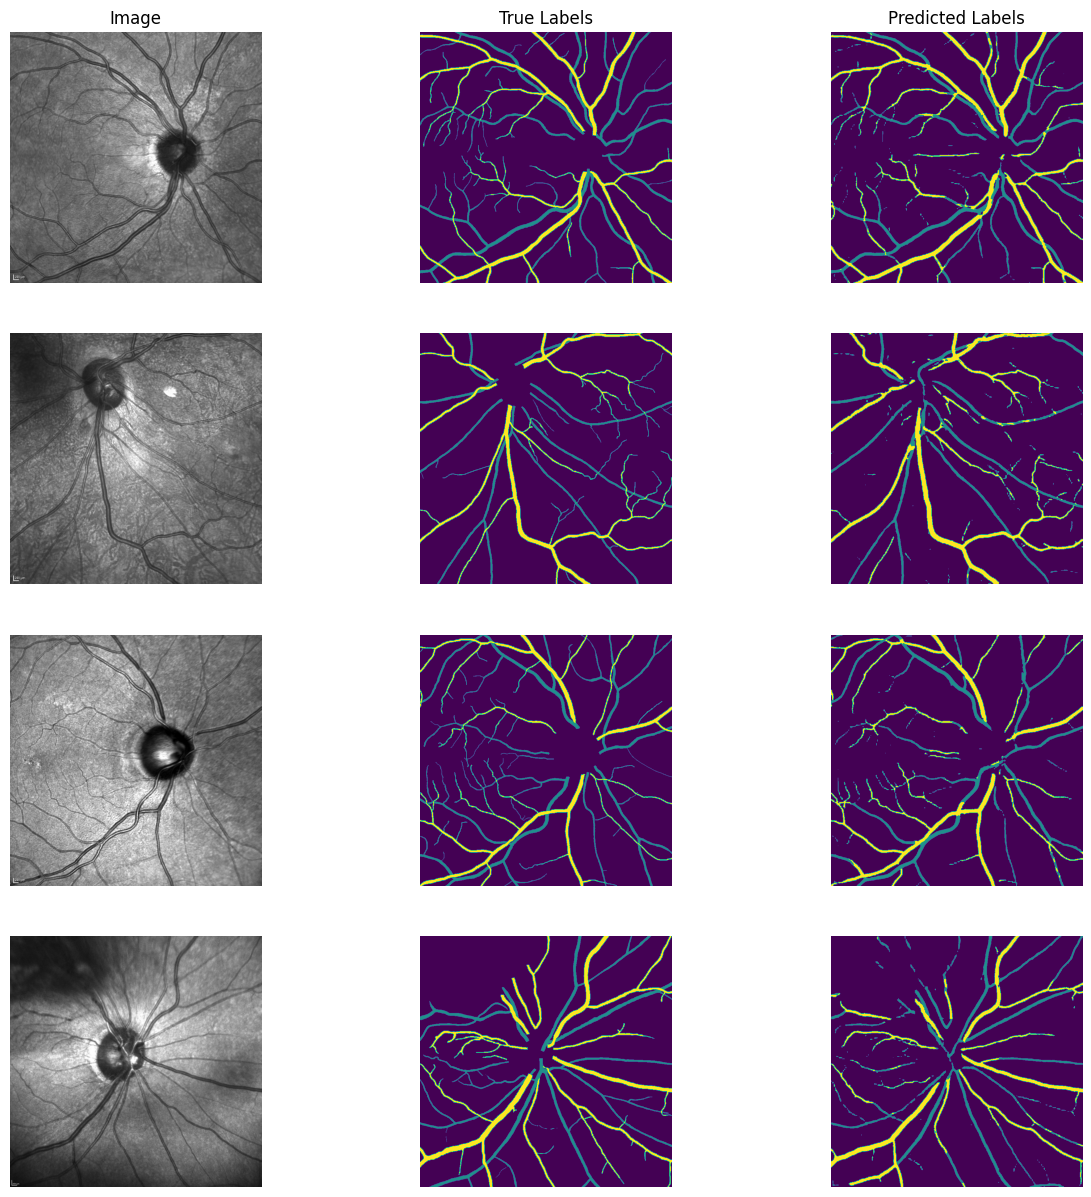

In [ ]:
# visually compare images to labels and network outputs
plt.figure()

f, axarr = plt.subplots(len(valid_dataset_test),3,figsize=(15, 15))
axarr[0,0].title.set_text('Image')
axarr[0,1].title.set_text('True Labels')
axarr[0,2].title.set_text('Predicted Labels')

for i in range(len(valid_dataset_test)):
  encoded_inputs = valid_dataset_test[i]
  mask = encoded_inputs["labels"]
  pixel_vals = encoded_inputs["pixel_values"].numpy()
  norm = norm = cv2.normalize(np.moveaxis(pixel_vals,0,-1), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
  axarr[i,0].imshow(norm)
  axarr[i,0].axis('off')
  axarr[i,1].imshow(mask.numpy())
  axarr[i,1].axis('off')
  axarr[i,2].imshow(reconstructed_outputs[i])
  axarr[i,2].axis('off')

  dice_arteries_total = []
  dice_veins_total = []
  metrics_total = []

  # create a table of metrics for each whole image
  for i in range(len(valid_dataset_test)):
    encoded_inputs = valid_dataset_test[i]
    true_labels = encoded_inputs["labels"].numpy()
    predictions = reconstructed_outputs[i]
    dice_arteries = dice(predictions, true_labels, label=1)
    dice_veins = dice(predictions, true_labels, label=2)
    dice_arteries_total.append(dice_arteries)
    dice_veins_total.append(dice_veins)
    target_names = ['background', 'arteries', 'veins']
    metrics = classification_report(true_labels.flatten(), predictions.flatten(), labels = [0,1,2], target_names=target_names, output_dict = True)
    metrics_total.append(metrics)



In [ ]:
ArteriesSummary = PrettyTable(["Accuracy (precision)","Sensitivity (recall)", "DICE"])
VeinsSummary = PrettyTable(["Accuracy (precision)","Sensitivity (recall)", "DICE"])
acc_veins = 0
acc_arteries = 0
sens_veins = 0
sens_arteries = 0
for index in range(len(metrics_total)):

    acc_arteries += metrics_total[index]['arteries']['precision']
    sens_arteries += metrics_total[index]['arteries']['recall']
    acc_veins += metrics_total[index]['veins']['precision']
    sens_veins += metrics_total[index]['veins']['recall']

ArteriesSummary.add_row([acc_arteries/len(dice_arteries_total), sens_arteries/len(dice_arteries_total), sum(dice_arteries_total)/len(dice_arteries_total)])
VeinsSummary.add_row([acc_veins/len(dice_veins_total), sens_veins/len(dice_veins_total), sum(dice_veins_total)/len(dice_veins_total)])

In [ ]:
print('Arteries Summary')
print(ArteriesSummary)

print('Veins Summary')
print(VeinsSummary)

Arteries Summary:
+----------------------+----------------------+--------------------+
| Accuracy (precision) | Sensitivity (recall) |        DICE        |
+----------------------+----------------------+--------------------+
|  0.7681968442975776  |  0.7572647776539811  | 0.2634924798575568 |
+----------------------+----------------------+--------------------+
Veins Summary:
+----------------------+----------------------+-------------------+
| Accuracy (precision) | Sensitivity (recall) |        DICE       |
+----------------------+----------------------+-------------------+
|  0.7970492333322253  |  0.8141777584586767  | 0.593811731040045 |
+----------------------+----------------------+-------------------+
